# YogaPartner

Our datasets are in
- `.\data\v1`
- `.\data\v2`

Our frontend code is in `.\android`

Our generated data goes in `.\intermediates`

Our augmented data goes in `.\aug`

Our models go in `.\models`

In [1]:
import os
from pathlib import Path
import re
import tqdm
import shutil
import time
import math

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from PIL import Image
import cv2

from difPy import dif

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.nn import relu6
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

## Global functions

In [2]:
version = 3
def getPath():
    return r".\data\v" + str(version)

def getClasses():
    path = getPath()
    return os.listdir(path)

def getPathOfClass(className):
    path = getPath()
    return os.path.join(path, className)

intermediates_dir = r".\intermediates\v" + str(version)
classFolders = getClasses()

## Dataset stats

In [28]:
def visualizeDataSet():
    counts = []
    imageTypes = {}
    for classFolder in classFolders:
        images = os.listdir(getPathOfClass(classFolder))
        count = len(images)
        counts.append(count)
        for image in images:
            image_path = os.path.join(getPathOfClass(classFolder), image)
            p = Path(image_path)
            ext = p.suffix
            imageTypes[ext] = imageTypes.get(ext, 0) + 1

    print("Dataset frequency distribution")
    for i in range(len(classFolders)):
        className = classFolders[i]
        count = counts[i]
        print(className + " : " + str(count))

    print()

    print("Image type frequency distribution")
    for key in imageTypes.keys():
        count = imageTypes[key]
        print(key + " : " + str(count))

    print()
    
visualizeDataSet()

Dataset frequency distribution
adho_mukha_shvanasana : 421
bhujangasana : 488
bidalasana : 293
phalakasana : 250
ustrasana : 203
utkatasana : 200
utkata_konasana : 200
virabhadrasana_i : 207
virabhadrasana_ii : 355
vrikshasana : 200

Image type frequency distribution
.jpg : 2777
.jpeg : 40



## Cleaning Data

### Convert to Jpeg

In [4]:
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for f in files:
        old_path = os.path.join(class_path, f)
        p = Path(old_path)
        ext = p.suffix
        if ext == ".webp":
            print("Converting " + f)
            new_file_name = f"{p.stem}.jepg"
            im = Image.open(old_path).convert("RGB")
            new_file_path = os.path.join(class_path, new_file_name)
            print(new_file_path)
            im.save(new_file_path, "jepg")
            print("Removing " + f)
            os.remove(old_path)
        if ext == ".png":
            print("Converting " + f)
            new_file_name = f"{p.stem}.jpg"
            im = Image.open(old_path).convert("RGB")
            new_file_path = os.path.join(class_path, new_file_name)
            print(new_file_path)
            im.save(new_file_path)
            print("Removing " + f)
            os.remove(old_path)
        if ext == ".JPG":
            print("Converting " + f)
            new_file_name = f"{p.stem}.jpg"
            im = Image.open(old_path).convert("RGB")
            new_file_path = os.path.join(class_path, new_file_name)
            print(new_file_path)
            im.save(new_file_path)
            print("Removing " + f)
            os.remove(old_path)
print("Converted Webp and PNG")

Converted Webp and PNG


### Finding duplicate images

In [5]:
for className in tqdm.tqdm(classFolders, position=0):
    class_path = getPathOfClass(className)
    search = dif(class_path, delete=True)
print("Completed duplicate image search")

 10%|████████▎                                                                          | 1/10 [00:44<06:40, 44.55s/it]

Found 0 images with one or more duplicate/similar images in 44.5507 seconds.


 20%|████████████████▌                                                                  | 2/10 [01:44<07:07, 53.42s/it]

Found 0 images with one or more duplicate/similar images in 59.6225 seconds.


 30%|████████████████████████▉                                                          | 3/10 [02:06<04:35, 39.34s/it]

Found 0 images with one or more duplicate/similar images in 22.5867 seconds.


 40%|█████████████████████████████████▏                                                 | 4/10 [02:26<03:09, 31.57s/it]

Found 0 images with one or more duplicate/similar images in 19.6559 seconds.


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:41<02:08, 25.65s/it]

Found 0 images with one or more duplicate/similar images in 15.1377 seconds.


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:54<01:25, 21.40s/it]

Found 0 images with one or more duplicate/similar images in 13.1518 seconds.


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:07<00:55, 18.54s/it]

Found 0 images with one or more duplicate/similar images in 12.6558 seconds.


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:18<00:32, 16.29s/it]

Found 0 images with one or more duplicate/similar images in 11.4747 seconds.


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:53<00:22, 22.17s/it]

Found 0 images with one or more duplicate/similar images in 35.1049 seconds.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:06<00:00, 24.61s/it]

Found 0 images with one or more duplicate/similar images in 12.1682 seconds.
Completed duplicate image search


### Cleaning up folder names

In [6]:
for className in classFolders:
    old_path = getPathOfClass(className)
    new_name = re.sub(r"\s+", "_", className)
    if new_name != className:
        print("Renaming " + className)
    new_path = os.path.join(getPath(), new_name)
    os.rename(old_path, new_path)
print("Renamed class names")

Renamed class names


### Removing non supported images

In [7]:
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    count = 1
    for f in files:
        f_path = os.path.join(class_path, f)
        if not (f.endswith(".jpg") or f.endswith(".jpeg")):
            os.remove(f_path)
            print("Removed " + f)
print("Finished removing non suporrted images")

Finished removing non suporrted images


### Cleaning up file names

In [30]:
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    count = 1
    for f in files:
        old_path = os.path.join(class_path, f)
        p = Path(old_path)
        new_file_name = f"{className}_{count}{p.suffix}"
        if new_file_name != f:
            print("Renaming " + f)
        new_file_path = os.path.join(class_path, new_file_name)
        if(os.path.exists(new_file_path)):
            print("Clash in names, change to unique pattern")
            break
        os.rename(old_path, new_file_path)
        count += 1
        
print("Finished cleaning file names")

Renaming adho_mukha_shvanasana_khbkhjbk1.jpg
Renaming adho_mukha_shvanasana_khbkhjbk10.jpg
Renaming adho_mukha_shvanasana_khbkhjbk100.jpg
Renaming adho_mukha_shvanasana_khbkhjbk101.jpg
Renaming adho_mukha_shvanasana_khbkhjbk102.jpg
Renaming adho_mukha_shvanasana_khbkhjbk103.jpg
Renaming adho_mukha_shvanasana_khbkhjbk104.jpg
Renaming adho_mukha_shvanasana_khbkhjbk105.jpg
Renaming adho_mukha_shvanasana_khbkhjbk106.jpg
Renaming adho_mukha_shvanasana_khbkhjbk107.jpg
Renaming adho_mukha_shvanasana_khbkhjbk108.jpg
Renaming adho_mukha_shvanasana_khbkhjbk109.jpg
Renaming adho_mukha_shvanasana_khbkhjbk11.jpg
Renaming adho_mukha_shvanasana_khbkhjbk110.jpg
Renaming adho_mukha_shvanasana_khbkhjbk111.jpg
Renaming adho_mukha_shvanasana_khbkhjbk112.jpg
Renaming adho_mukha_shvanasana_khbkhjbk113.jpg
Renaming adho_mukha_shvanasana_khbkhjbk114.jpg
Renaming adho_mukha_shvanasana_khbkhjbk115.jpg
Renaming adho_mukha_shvanasana_khbkhjbk116.jpg
Renaming adho_mukha_shvanasana_khbkhjbk117.jpg
Renaming adho_muk

Renaming adho_mukha_shvanasana_khbkhjbk363.jpg
Renaming adho_mukha_shvanasana_khbkhjbk364.jpg
Renaming adho_mukha_shvanasana_khbkhjbk365.jpg
Renaming adho_mukha_shvanasana_khbkhjbk366.jpg
Renaming adho_mukha_shvanasana_khbkhjbk367.jpg
Renaming adho_mukha_shvanasana_khbkhjbk368.jpg
Renaming adho_mukha_shvanasana_khbkhjbk369.jpg
Renaming adho_mukha_shvanasana_khbkhjbk37.jpg
Renaming adho_mukha_shvanasana_khbkhjbk370.jpg
Renaming adho_mukha_shvanasana_khbkhjbk371.jpg
Renaming adho_mukha_shvanasana_khbkhjbk372.jpg
Renaming adho_mukha_shvanasana_khbkhjbk373.jpg
Renaming adho_mukha_shvanasana_khbkhjbk374.jpg
Renaming adho_mukha_shvanasana_khbkhjbk375.jpg
Renaming adho_mukha_shvanasana_khbkhjbk376.jpg
Renaming adho_mukha_shvanasana_khbkhjbk377.jpg
Renaming adho_mukha_shvanasana_khbkhjbk378.jpg
Renaming adho_mukha_shvanasana_khbkhjbk379.jpg
Renaming adho_mukha_shvanasana_khbkhjbk38.jpg
Renaming adho_mukha_shvanasana_khbkhjbk380.jpg
Renaming adho_mukha_shvanasana_khbkhjbk381.jpg
Renaming adho_m

Renaming bhujangasana_khbkhjbk258.jpg
Renaming bhujangasana_khbkhjbk259.jpg
Renaming bhujangasana_khbkhjbk26.jpg
Renaming bhujangasana_khbkhjbk260.jpg
Renaming bhujangasana_khbkhjbk261.jpg
Renaming bhujangasana_khbkhjbk262.jpg
Renaming bhujangasana_khbkhjbk263.jpg
Renaming bhujangasana_khbkhjbk264.jpg
Renaming bhujangasana_khbkhjbk265.jpg
Renaming bhujangasana_khbkhjbk266.jpg
Renaming bhujangasana_khbkhjbk267.jpg
Renaming bhujangasana_khbkhjbk268.jpg
Renaming bhujangasana_khbkhjbk269.jpg
Renaming bhujangasana_khbkhjbk27.jpg
Renaming bhujangasana_khbkhjbk270.jpg
Renaming bhujangasana_khbkhjbk271.jpg
Renaming bhujangasana_khbkhjbk272.jpg
Renaming bhujangasana_khbkhjbk273.jpg
Renaming bhujangasana_khbkhjbk274.jpg
Renaming bhujangasana_khbkhjbk275.jpg
Renaming bhujangasana_khbkhjbk276.jpg
Renaming bhujangasana_khbkhjbk277.jpg
Renaming bhujangasana_khbkhjbk278.jpg
Renaming bhujangasana_khbkhjbk279.jpg
Renaming bhujangasana_khbkhjbk28.jpg
Renaming bhujangasana_khbkhjbk280.jpg
Renaming bhujan

Renaming bhujangasana_khbkhjbk59.jpg
Renaming bhujangasana_khbkhjbk6.jpg
Renaming bhujangasana_khbkhjbk60.jpg
Renaming bhujangasana_khbkhjbk61.jpg
Renaming bhujangasana_khbkhjbk62.jpg
Renaming bhujangasana_khbkhjbk63.jpg
Renaming bhujangasana_khbkhjbk64.jpg
Renaming bhujangasana_khbkhjbk65.jpg
Renaming bhujangasana_khbkhjbk66.jpg
Renaming bhujangasana_khbkhjbk67.jpg
Renaming bhujangasana_khbkhjbk68.jpg
Renaming bhujangasana_khbkhjbk69.jpg
Renaming bhujangasana_khbkhjbk7.jpg
Renaming bhujangasana_khbkhjbk70.jpg
Renaming bhujangasana_khbkhjbk71.jpg
Renaming bhujangasana_khbkhjbk72.jpg
Renaming bhujangasana_khbkhjbk73.jpg
Renaming bhujangasana_khbkhjbk74.jpg
Renaming bhujangasana_khbkhjbk75.jpg
Renaming bhujangasana_khbkhjbk76.jpg
Renaming bhujangasana_khbkhjbk77.jpg
Renaming bhujangasana_khbkhjbk78.jpg
Renaming bhujangasana_khbkhjbk79.jpg
Renaming bhujangasana_khbkhjbk8.jpg
Renaming bhujangasana_khbkhjbk80.jpg
Renaming bhujangasana_khbkhjbk81.jpg
Renaming bhujangasana_khbkhjbk82.jpg
Rena

Renaming bidalasana_khbkhjbk291.jpg
Renaming bidalasana_khbkhjbk292.jpg
Renaming bidalasana_khbkhjbk293.jpg
Renaming bidalasana_khbkhjbk3.jpg
Renaming bidalasana_khbkhjbk30.jpg
Renaming bidalasana_khbkhjbk31.jpg
Renaming bidalasana_khbkhjbk32.jpeg
Renaming bidalasana_khbkhjbk33.jpg
Renaming bidalasana_khbkhjbk34.jpg
Renaming bidalasana_khbkhjbk35.jpg
Renaming bidalasana_khbkhjbk36.jpg
Renaming bidalasana_khbkhjbk37.jpg
Renaming bidalasana_khbkhjbk38.jpg
Renaming bidalasana_khbkhjbk39.jpg
Renaming bidalasana_khbkhjbk4.jpg
Renaming bidalasana_khbkhjbk40.jpg
Renaming bidalasana_khbkhjbk41.jpg
Renaming bidalasana_khbkhjbk42.jpg
Renaming bidalasana_khbkhjbk43.jpg
Renaming bidalasana_khbkhjbk44.jpg
Renaming bidalasana_khbkhjbk45.jpg
Renaming bidalasana_khbkhjbk46.jpg
Renaming bidalasana_khbkhjbk47.jpg
Renaming bidalasana_khbkhjbk48.jpg
Renaming bidalasana_khbkhjbk49.jpg
Renaming bidalasana_khbkhjbk5.jpg
Renaming bidalasana_khbkhjbk50.jpg
Renaming bidalasana_khbkhjbk51.jpg
Renaming bidalasana

Renaming phalakasana_khbkhjbk97.jpg
Renaming phalakasana_khbkhjbk98.jpg
Renaming phalakasana_khbkhjbk99.jpg
Renaming ustrasana_khbkhjbk1.jpg
Renaming ustrasana_khbkhjbk10.jpg
Renaming ustrasana_khbkhjbk100.jpg
Renaming ustrasana_khbkhjbk101.jpg
Renaming ustrasana_khbkhjbk102.jpg
Renaming ustrasana_khbkhjbk103.jpg
Renaming ustrasana_khbkhjbk104.jpg
Renaming ustrasana_khbkhjbk105.jpg
Renaming ustrasana_khbkhjbk106.jpg
Renaming ustrasana_khbkhjbk107.jpg
Renaming ustrasana_khbkhjbk108.jpg
Renaming ustrasana_khbkhjbk109.jpg
Renaming ustrasana_khbkhjbk11.jpg
Renaming ustrasana_khbkhjbk110.jpg
Renaming ustrasana_khbkhjbk111.jpg
Renaming ustrasana_khbkhjbk112.jpg
Renaming ustrasana_khbkhjbk113.jpg
Renaming ustrasana_khbkhjbk114.jpg
Renaming ustrasana_khbkhjbk115.jpg
Renaming ustrasana_khbkhjbk116.jpg
Renaming ustrasana_khbkhjbk117.jpg
Renaming ustrasana_khbkhjbk118.jpg
Renaming ustrasana_khbkhjbk119.jpg
Renaming ustrasana_khbkhjbk12.jpg
Renaming ustrasana_khbkhjbk120.jpg
Renaming ustrasana_khb

Renaming utkatasana_khbkhjbk177.jpg
Renaming utkatasana_khbkhjbk178.jpg
Renaming utkatasana_khbkhjbk179.jpg
Renaming utkatasana_khbkhjbk18.jpg
Renaming utkatasana_khbkhjbk180.jpg
Renaming utkatasana_khbkhjbk181.jpg
Renaming utkatasana_khbkhjbk182.jpg
Renaming utkatasana_khbkhjbk183.jpg
Renaming utkatasana_khbkhjbk184.jpg
Renaming utkatasana_khbkhjbk185.jpg
Renaming utkatasana_khbkhjbk186.jpg
Renaming utkatasana_khbkhjbk187.jpg
Renaming utkatasana_khbkhjbk188.jpg
Renaming utkatasana_khbkhjbk189.jpg
Renaming utkatasana_khbkhjbk19.jpg
Renaming utkatasana_khbkhjbk190.jpg
Renaming utkatasana_khbkhjbk191.jpg
Renaming utkatasana_khbkhjbk192.jpg
Renaming utkatasana_khbkhjbk193.jpg
Renaming utkatasana_khbkhjbk194.jpg
Renaming utkatasana_khbkhjbk195.jpg
Renaming utkatasana_khbkhjbk196.jpg
Renaming utkatasana_khbkhjbk197.jpg
Renaming utkatasana_khbkhjbk198.jpg
Renaming utkatasana_khbkhjbk199.jpg
Renaming utkatasana_khbkhjbk2.jpg
Renaming utkatasana_khbkhjbk20.jpg
Renaming utkatasana_khbkhjbk200.j

Renaming virabhadrasana_i_khbkhjbk106.jpg
Renaming virabhadrasana_i_khbkhjbk107.jpg
Renaming virabhadrasana_i_khbkhjbk108.jpg
Renaming virabhadrasana_i_khbkhjbk109.jpg
Renaming virabhadrasana_i_khbkhjbk11.jpg
Renaming virabhadrasana_i_khbkhjbk110.jpg
Renaming virabhadrasana_i_khbkhjbk111.jpg
Renaming virabhadrasana_i_khbkhjbk112.jpg
Renaming virabhadrasana_i_khbkhjbk113.jpg
Renaming virabhadrasana_i_khbkhjbk114.jpg
Renaming virabhadrasana_i_khbkhjbk115.jpg
Renaming virabhadrasana_i_khbkhjbk116.jpg
Renaming virabhadrasana_i_khbkhjbk117.jpg
Renaming virabhadrasana_i_khbkhjbk118.jpg
Renaming virabhadrasana_i_khbkhjbk119.jpg
Renaming virabhadrasana_i_khbkhjbk12.jpg
Renaming virabhadrasana_i_khbkhjbk120.jpg
Renaming virabhadrasana_i_khbkhjbk121.jpg
Renaming virabhadrasana_i_khbkhjbk122.jpg
Renaming virabhadrasana_i_khbkhjbk123.jpg
Renaming virabhadrasana_i_khbkhjbk124.jpg
Renaming virabhadrasana_i_khbkhjbk125.jpg
Renaming virabhadrasana_i_khbkhjbk126.jpg
Renaming virabhadrasana_i_khbkhjbk12

Renaming virabhadrasana_ii_khbkhjbk189.jpg
Renaming virabhadrasana_ii_khbkhjbk19.jpg
Renaming virabhadrasana_ii_khbkhjbk190.jpg
Renaming virabhadrasana_ii_khbkhjbk191.jpg
Renaming virabhadrasana_ii_khbkhjbk192.jpg
Renaming virabhadrasana_ii_khbkhjbk193.jpg
Renaming virabhadrasana_ii_khbkhjbk194.jpg
Renaming virabhadrasana_ii_khbkhjbk195.jpg
Renaming virabhadrasana_ii_khbkhjbk196.jpg
Renaming virabhadrasana_ii_khbkhjbk197.jpg
Renaming virabhadrasana_ii_khbkhjbk198.jpg
Renaming virabhadrasana_ii_khbkhjbk199.jpg
Renaming virabhadrasana_ii_khbkhjbk2.jpg
Renaming virabhadrasana_ii_khbkhjbk20.jpg
Renaming virabhadrasana_ii_khbkhjbk200.jpg
Renaming virabhadrasana_ii_khbkhjbk201.jpg
Renaming virabhadrasana_ii_khbkhjbk202.jpg
Renaming virabhadrasana_ii_khbkhjbk203.jpg
Renaming virabhadrasana_ii_khbkhjbk204.jpg
Renaming virabhadrasana_ii_khbkhjbk205.jpg
Renaming virabhadrasana_ii_khbkhjbk206.jpg
Renaming virabhadrasana_ii_khbkhjbk207.jpg
Renaming virabhadrasana_ii_khbkhjbk208.jpg
Renaming virabh

Renaming vrikshasana_khbkhjbk150.jpg
Renaming vrikshasana_khbkhjbk151.jpg
Renaming vrikshasana_khbkhjbk152.jpg
Renaming vrikshasana_khbkhjbk153.jpg
Renaming vrikshasana_khbkhjbk154.jpg
Renaming vrikshasana_khbkhjbk155.jpg
Renaming vrikshasana_khbkhjbk156.jpg
Renaming vrikshasana_khbkhjbk157.jpg
Renaming vrikshasana_khbkhjbk158.jpg
Renaming vrikshasana_khbkhjbk159.jpg
Renaming vrikshasana_khbkhjbk16.jpg
Renaming vrikshasana_khbkhjbk160.jpg
Renaming vrikshasana_khbkhjbk161.jpg
Renaming vrikshasana_khbkhjbk162.jpg
Renaming vrikshasana_khbkhjbk163.jpg
Renaming vrikshasana_khbkhjbk164.jpg
Renaming vrikshasana_khbkhjbk165.jpg
Renaming vrikshasana_khbkhjbk166.jpg
Renaming vrikshasana_khbkhjbk167.jpg
Renaming vrikshasana_khbkhjbk168.jpg
Renaming vrikshasana_khbkhjbk169.jpg
Renaming vrikshasana_khbkhjbk17.jpg
Renaming vrikshasana_khbkhjbk170.jpg
Renaming vrikshasana_khbkhjbk171.jpg
Renaming vrikshasana_khbkhjbk172.jpg
Renaming vrikshasana_khbkhjbk173.jpg
Renaming vrikshasana_khbkhjbk174.jpg
Ren

### Removing truncated images

In [10]:
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for file in files:
        fpath = os.path.join(class_path, file)
        img = Image.open(fpath)
        try:
            img.getpixel((0,0))
            plt.imread(fpath)
        except OSError as e:
            print("Please delete "+ fpath)
            
print("Done")

Done


### Cleaning to (h, w, 3) format

In [11]:
classFolders = getClasses()
for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for file in files:
        fpath = os.path.join(class_path, file)
        img = plt.imread(fpath)
        if not (len(img.shape) == 3 and img.shape[2] == 3):
            print(fpath)
            
print("Done")

Done


In [31]:
visualizeDataSet()

Dataset frequency distribution
adho_mukha_shvanasana : 421
bhujangasana : 488
bidalasana : 293
phalakasana : 250
ustrasana : 203
utkatasana : 200
utkata_konasana : 200
virabhadrasana_i : 207
virabhadrasana_ii : 355
vrikshasana : 200

Image type frequency distribution
.jpg : 2777
.jpeg : 40



## Pre-process

In [32]:
filepaths = []
labels = []

for className in classFolders:
    class_path = getPathOfClass(className)
    files = os.listdir(class_path)
    for f in files:
        fpath = os.path.join(class_path, f)
        filepaths.append(fpath)
        labels.append(className)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

trim_classes_to_count = 200

df = df.copy()
sample_list=[] 
groups = df.groupby('labels')
for label in df['labels'].unique():        
    group = groups.get_group(label)
    sample_count = len(group)         
    if sample_count > trim_classes_to_count :
        group = group.sample(
            trim_classes_to_count, 
            replace=False, 
            weights=None, 
            random_state=123, 
            axis=0
        ).reset_index(drop=True)
    sample_list.append(group)
df = pd.concat(sample_list, axis=0).reset_index(drop=True)
balance = list(df['labels'].value_counts())
print(balance)

trsplit = 0.8
# 20% - 10% test, 10% validation
tsplit = 0.2
strat=df['labels']    
train_df, test_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), ' total length: ', len(filepaths))
print(train_df['labels'].value_counts())

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
train_df length:  1600   test_df length:  400  total length:  2817
bhujangasana             160
ustrasana                160
phalakasana              160
utkata_konasana          160
bidalasana               160
adho_mukha_shvanasana    160
vrikshasana              160
virabhadrasana_ii        160
virabhadrasana_i         160
utkatasana               160
Name: labels, dtype: int64


In [33]:
train_df

,filepaths,labels
201,.\data\v3\bhujangasana\bhujangasana_59.jpg,bhujangasana
304,.\data\v3\bhujangasana\bhujangasana_117.jpg,bhujangasana
278,.\data\v3\bhujangasana\bhujangasana_137.jpg,bhujangasana
814,.\data\v3\ustrasana\ustrasana_171.jpg,ustrasana
316,.\data\v3\bhujangasana\bhujangasana_384.jpg,bhujangasana
...,...,...
1913,.\data\v3\vrikshasana\vrikshasana_200.jpg,vrikshasana
20,.\data\v3\adho_mukha_shvanasana\adho_mukha_shv...,adho_mukha_shvanasana
1085,.\data\v3\utkatasana\utkatasana_176.jpg,utkatasana
597,.\data\v3\bidalasana\bidalasana_23.jpg,bidalasana


## Running pre-trained detection model

### Save detected poses of training set for debugging

In [79]:
landmark_count = 33

def saveImagesWithKeypoints(image_path, results):
    image_path = os.path.abspath(image_path)
    try:
        image = cv2.imread(image_path)
        image = image.copy()
        pose_landmarks = results.pose_landmarks
        if pose_landmarks is not None and len(pose_landmarks.landmark) == landmark_count:
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
            )
            
        p = Path(image_path)
        fileName = p.name
        fp = os.path.join(intermediates_dir, fileName)
        fp = r""+os.path.abspath(fp)
        if not cv2.imwrite(fp, image):
            raise Exception("image not saved to {}".format(fp))
    except (Exception) as e:
        print("Failed to write image for {}".format(image_path))
        raise e

def process_result(result, image_shape, image_path, class_name):
    pose_landmarks = result.pose_landmarks
    if pose_landmarks is not None and len(pose_landmarks.landmark) == landmark_count:
        pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]
        # Map pose landmarks from [0, 1] range to absolute coordinates to get correct aspect ratio.
        frame_height, frame_width = image_shape
        pose_landmarks *= np.array([frame_width, frame_height, frame_width])
        pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(str).tolist()
    else:
        print("Pose was none or len < {} for {}".format(landmark_count, image_path))
    return (class_name, pose_landmarks)

durations = []
def detect(ndf):
    with mp_pose.Pose(
        static_image_mode=True, 
    #     min_detection_confidence=0.6, 
        model_complexity=1
    ) as pose:
        rows = []
        for i, value in tqdm.tqdm(ndf.iterrows(), position=0):
            begin = time.time()
            label = value['labels']
            image_path = value['filepaths']
            image = cv2.imread(image_path)
            results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            end = time.time()
            rows.append(process_result(results, image.shape[:2], image_path, label))
            saveImagesWithKeypoints(image_path, results)
            if results.pose_landmarks is not None:
                durations.append(end - begin)   
        return rows
    
train_in = detect(train_df)
test_in = detect(test_df)
print("Done detecting")
print("Total time taken - " + str(sum(durations)))
print("Max time taken - " + str(max(durations)))
print("Min time taken - " + str(min(durations)))
print("Average time taken - " + str(sum(durations) / len(durations)))

1600it [05:13,  5.11it/s]
400it [01:13,  5.41it/s]

Done detecting
Total time taken - 289.4641752243042
Max time taken - 1.1931376457214355
Min time taken - 0.08200597763061523
Average time taken - 0.1447320876121521


## Train classifier model

### Classes

In [80]:
labels_list = [
    "adho_mukha_shvanasana",
    "bhujangasana",
    "bidalasana",
    "phalakasana",
    "ustrasana",
    "utkatasana",
    "utkata_konasana",
    "virabhadrasana_i",
    "virabhadrasana_ii",
    "vrikshasana",
]

### Pre-processing

In [101]:
TORSO_MULTIPLIER = 2.5

def load_as_df(class_to_landmarks):
    y = [entry[0] for entry in class_to_landmarks]
    y = np_utils.to_categorical([labels_list.index(className) for className in y])
    x = [entry[1] for entry in class_to_landmarks]
    return x, y

def get_xyz(entry, body_part_index):
    x = entry[body_part_index * 3]
    y = entry[body_part_index * 3 + 1]
    z = entry[body_part_index * 3 + 2]
    return (x, y, z)

def average(a, b):
    ax = float(a[0])
    ay = float(a[1])
    az = float(a[2])
    bx = float(b[0])
    by = float(b[1])
    bz = float(b[2])
    return ((ax + bx) * 0.5, (ay + by) * 0.5, (az + bz) * 0.5)

def subtract(a, b):
    ax = float(a[0])
    ay = float(a[1])
    az = float(a[2])
    bx = float(b[0])
    by = float(b[1])
    bz = float(b[2])
    return (ax - bx, ay - by, az - bz)

def multiply(a, multiple):
    ax = float(a[0])
    ay = float(a[1])
    az = float(a[2])
    return (ax * multiple, ay * multiple, az * multiple)

def l2Norm2D(a):
    ax = float(a[0])
    ay = float(a[1])
    return math.hypot(ax, ay)

def get_pose_size(landmarks):
    #Note: This approach uses only 2D landmarks to compute pose size as using Z wasn't helpful
    hips_center = average(
        landmarks[mp_pose.PoseLandmark.LEFT_HIP], 
        landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
    )
    shoulders_center = average(
        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER],
        landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    )
    torso_size = l2Norm2D(subtract(hips_center, shoulders_center))
    max_distance = torso_size * TORSO_MULTIPLIER
    # torsoSize * TORSO_MULTIPLIER is the floor we want but actual size
    # can be bigger for a given pose depending on extension of limbs etc so we calculate that.
    for landmark in landmarks:
        distance = l2Norm2D(subtract(hips_center, landmark))
        if (distance > max_distance):
            max_distance = distance
    return max_distance

def normalize(entry):
    normalized = list(zip(*[iter(entry)]*3))
    left_hip = normalized[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = normalized[mp_pose.PoseLandmark.RIGHT_HIP]
    hip_center = average(left_hip, right_hip)
    normalized = [subtract(point, hip_center) for point in normalized]
    pose_size = get_pose_size(normalized)
    normalized = [multiply(point, 1 / pose_size) for point in normalized]
    #Multiplication by 100 is not required, but makes it easier to debug.
    normalized = [multiply(point, 100) for point in normalized]
    return normalized
    
def get_embedding(entry):
    embeddings = []

    # We use several pairwise 3D distances to form pose embedding. These were selected
    # based on experimentation for best results

    # Group our distances by number of joints between the pairs.
    # One joint. - (9)
    embeddings.append(
        subtract(
            average(entry[mp_pose.PoseLandmark.LEFT_SHOULDER], entry[mp_pose.PoseLandmark.RIGHT_SHOULDER]),
            average(entry[mp_pose.PoseLandmark.LEFT_HIP], entry[mp_pose.PoseLandmark.RIGHT_HIP])
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_SHOULDER],
            entry[mp_pose.PoseLandmark.LEFT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ELBOW],
            entry[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_ELBOW]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.RIGHT_ELBOW]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_KNEE],
            entry[mp_pose.PoseLandmark.LEFT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_KNEE],
            entry[mp_pose.PoseLandmark.RIGHT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_ANKLE],
            entry[mp_pose.PoseLandmark.LEFT_KNEE]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ANKLE],
            entry[mp_pose.PoseLandmark.RIGHT_KNEE]
        )
    )
    
    # Two joints. (4)
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_ANKLE],
            entry[mp_pose.PoseLandmark.LEFT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ANKLE],
            entry[mp_pose.PoseLandmark.RIGHT_HIP]
        )
    )

    # Four joints. (2)
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.RIGHT_HIP]
        )
    )

    # Five joints. (4)
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_ANKLE],
            entry[mp_pose.PoseLandmark.LEFT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ANKLE],
            entry[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.LEFT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_HIP]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.RIGHT_HIP]
        )
    )

    # Cross body. (4)
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ELBOW],
            entry[mp_pose.PoseLandmark.LEFT_ELBOW]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_KNEE],
            entry[mp_pose.PoseLandmark.LEFT_KNEE]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_WRIST],
            entry[mp_pose.PoseLandmark.LEFT_WRIST]
        )
    )
    embeddings.append(
        subtract(
            entry[mp_pose.PoseLandmark.RIGHT_ANKLE],
            entry[mp_pose.PoseLandmark.LEFT_ANKLE]
        )
    )
    return embeddings
    
def pre_process(x):
    processed_x = []
    for entry in x:
        normalized_landmarks = normalize(entry)
        embeddings = get_embedding(normalized_landmarks)
        flattened_embeddings = [point_f for feature in embeddings for point_f in feature]
        processed_x.append(flattened_embeddings)
    return tf.convert_to_tensor(processed_x)

X_train, y_train = load_as_df(train_in)
X_test_in, y_test_in = load_as_df(test_in)

# split test to test and validation (50-50 = 10% each)
X_test, X_val, y_test, y_val = train_test_split(X_test_in, y_test_in, test_size=0.5, shuffle=True, random_state=123)

processed_X_train = pre_process(X_train)
processed_X_val =  pre_process(X_val)
processed_X_test = pre_process(X_test)

print("Count of classes:")
print(len(labels_list))
print("Size of train x, y :")
print(len(processed_X_train))
print(len(y_train))
print("Size of test x, y :")
print(len(processed_X_test))
print(len(y_test))
print("Size of val x, y :")
print(len(processed_X_val))
print(len(y_val))

Count of classes:
10
Size of train x, y :
1600
1600
Size of test x, y :
200
200
Size of val x, y :
200
200


In [102]:
processed_X_train[50:51]

<tf.Tensor: shape=(1, 69), dtype=float32, numpy=
array([[ 1.87771835e+01, -3.53187981e+01, -5.01123381e+00,
        -1.14892113e+00,  7.93644071e-01,  8.71949615e+01,
         6.73930311e+00, -1.82415161e+01,  1.31717606e+01,
         4.28081083e+00, -1.96150570e+01, -4.38385201e+00,
         3.08418489e+00, -1.67168007e+01, -3.15798264e+01,
         2.84084625e+01,  1.13012314e+01, -5.59262180e+00,
         2.58527012e+01,  1.09589453e+01, -5.54583549e+00,
        -1.36984720e+01,  2.93216381e+01,  2.32557716e+01,
        -1.06736298e+01,  2.72137470e+01,  2.32078571e+01,
         1.14396629e+01, -3.89665489e+01, -4.16711807e+01,
         9.82348824e+00, -3.49583168e+01, -1.84080658e+01,
         1.47099905e+01,  4.06228714e+01,  1.76631489e+01,
         1.51790714e+01,  3.81726913e+01,  1.76620216e+01,
         3.05890961e+01, -7.47012253e+01, -5.80361214e+01,
         2.82284222e+01, -6.98612289e+01, -1.20655928e+01,
        -4.43944168e+00,  7.63575516e+01,  3.40280914e+01,
       

In [104]:
y_train[50:51]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [105]:
# inputs = tf.keras.Input(shape=(99))
# layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
# layer = keras.layers.Dropout(0.5)(layer)
# layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dropout(0.5)(layer)
# outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

# model = keras.Model(inputs, outputs)

inputs = tf.keras.Input(shape=(69))
model = Sequential()
model.add(inputs)
model.add(Dense(128, activation=relu6))
model.add(Dropout(0.5))
model.add(Dense(64, activation=relu6))
model.add(Dropout(0.5))
model.add(Dense(len(labels_list), activation="softmax"))

# optimizer = SGD(
#     learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
# )

optimizer = Adam()

model.compile(
    optimizer = optimizer,
    loss = CategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest validation accuracy.
checkpoint_path = "models/weights.best.hdf5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor ='val_accuracy',
    verbose = 1,
    save_best_only = True,
    mode ='max'
)

earlystopping = EarlyStopping(monitor ='val_accuracy', patience = 20)

# Start training
model_history = model.fit(
    processed_X_train, 
    y_train,
    epochs = 200,
    batch_size = 16,
    validation_data = (processed_X_val, y_val),
    callbacks = [
#         checkpoint, 
#         earlystopping
    ]
)

Epoch 1/200
100/100 [==============================] - 2s 8ms/step - loss: 4.9727 - accuracy: 0.1656 - val_loss: 1.5333 - val_accuracy: 0.4100
Epoch 2/200
100/100 [==============================] - 0s 4ms/step - loss: 2.6411 - accuracy: 0.2788 - val_loss: 1.4793 - val_accuracy: 0.5650
Epoch 3/200
100/100 [==============================] - 0s 3ms/step - loss: 1.9823 - accuracy: 0.3494 - val_loss: 1.2798 - val_accuracy: 0.6900
Epoch 4/200
100/100 [==============================] - 0s 3ms/step - loss: 1.6771 - accuracy: 0.4244 - val_loss: 1.0442 - val_accuracy: 0.7250
Epoch 5/200
100/100 [==============================] - 0s 3ms/step - loss: 1.4788 - accuracy: 0.4669 - val_loss: 0.8074 - val_accuracy: 0.8250
Epoch 6/200
100/100 [==============================] - 0s 3ms/step - loss: 1.3064 - accuracy: 0.5244 - val_loss: 0.7003 - val_accuracy: 0.8500
Epoch 7/200
100/100 [==============================] - 0s 3ms/step - loss: 1.1974 - accuracy: 0.5694 - val_loss: 0.6419 - val_accuracy: 0.8900

Epoch 58/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.8969 - val_loss: 0.0857 - val_accuracy: 0.9700
Epoch 59/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2588 - accuracy: 0.9075 - val_loss: 0.0933 - val_accuracy: 0.9600
Epoch 60/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.9112 - val_loss: 0.1069 - val_accuracy: 0.9600
Epoch 61/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2644 - accuracy: 0.9169 - val_loss: 0.0725 - val_accuracy: 0.9650
Epoch 62/200
100/100 [==============================] - 0s 4ms/step - loss: 0.2267 - accuracy: 0.9181 - val_loss: 0.0960 - val_accuracy: 0.9600
Epoch 63/200
100/100 [==============================] - 0s 4ms/step - loss: 0.2682 - accuracy: 0.9087 - val_loss: 0.1185 - val_accuracy: 0.9650
Epoch 64/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2279 - accuracy: 0.9256 - val_loss: 0.0889 - val_accuracy:

Epoch 115/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1592 - accuracy: 0.9438 - val_loss: 0.0667 - val_accuracy: 0.9900
Epoch 116/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.9463 - val_loss: 0.0575 - val_accuracy: 0.9900
Epoch 117/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1570 - accuracy: 0.9463 - val_loss: 0.0557 - val_accuracy: 0.9900
Epoch 118/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1600 - accuracy: 0.9500 - val_loss: 0.0561 - val_accuracy: 0.9850
Epoch 119/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1756 - accuracy: 0.9469 - val_loss: 0.0583 - val_accuracy: 0.9900
Epoch 120/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1632 - accuracy: 0.9444 - val_loss: 0.0452 - val_accuracy: 0.9900
Epoch 121/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1623 - accuracy: 0.9450 - val_loss: 0.0426 - val_ac

100/100 [==============================] - 0s 3ms/step - loss: 0.1695 - accuracy: 0.9388 - val_loss: 0.0439 - val_accuracy: 0.9900
Epoch 172/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1663 - accuracy: 0.9469 - val_loss: 0.0589 - val_accuracy: 0.9800
Epoch 173/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1801 - accuracy: 0.9431 - val_loss: 0.0581 - val_accuracy: 0.9800
Epoch 174/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1576 - accuracy: 0.9475 - val_loss: 0.0399 - val_accuracy: 0.9900
Epoch 175/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1327 - accuracy: 0.9563 - val_loss: 0.0551 - val_accuracy: 0.9800
Epoch 176/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1380 - accuracy: 0.9531 - val_loss: 0.0502 - val_accuracy: 0.9850
Epoch 177/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1429 - accuracy: 0.9594 - val_loss: 0.0621 - val_accuracy: 0.9800

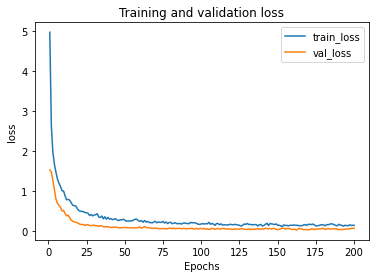

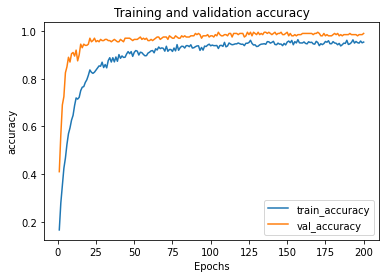

In [106]:
def show_val_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

show_val_metric(model_history, 'loss')
show_val_metric(model_history, 'accuracy')

### Convert and save tflite model

In [107]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
ct = time.strftime("%Y%m%d-%H%M%S")
open("models/converted_model{}.tflite".format(ct), "wb").write(tflite_model)
print("Done")

INFO:tensorflow:Assets written to: C:\Users\CYBERS~1\AppData\Local\Temp\tmpjgyzpw4a\assets


Done


## Testing model

In [108]:
loss, accuracy = model.evaluate(processed_X_test, y_test, verbose = 0)
print("=====================Loss=======================")
print('Loss : ', loss)
print("Accuracy : ", accuracy)

y_test_pred_model = model.predict(processed_X_test)
y_test_pred = np_utils.to_categorical(np.argmax(y_test_pred_model, axis=1))

print("=====================Accuracy=======================")
print(accuracy_score(y_test, y_test_pred))

print("=====================Classification Report=======================")
print(classification_report(y_test, y_test_pred, target_names = labels_list))

print("=====================Confusion Matrix=======================")
y_pred_classes = [labels_list[i] for i in np.argmax(y_test_pred_model, axis=1)]
y_test_classes = [labels_list[i] for i in np.argmax(y_test, axis=1)]

con_matrix = confusion_matrix(y_test_classes, y_pred_classes, labels=labels_list)
print(con_matrix)

=====================Loss=======================
Loss :  0.01268979161977768
Accuracy :  0.9950000047683716
=====================Accuracy=======================
0.995
=====================Classification Report=======================
                       precision    recall  f1-score   support

adho_mukha_shvanasana       1.00      1.00      1.00        24
         bhujangasana       1.00      1.00      1.00        15
           bidalasana       1.00      1.00      1.00        15
          phalakasana       1.00      1.00      1.00        22
            ustrasana       1.00      1.00      1.00        22
           utkatasana       1.00      0.95      0.98        22
      utkata_konasana       1.00      1.00      1.00        24
     virabhadrasana_i       1.00      1.00      1.00        16
    virabhadrasana_ii       1.00      1.00      1.00        22
          vrikshasana       0.95      1.00      0.97        18

            micro avg       0.99      0.99      0.99       200
         

In [110]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               8960      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 17,866
Trainable params: 17,866
Non-trainable params: 0
_________________________________________________________________
